<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Anomaly_Sound_Detection_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[機械稼働音の異常検知](https://signate.jp/competitions/358)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
checkpoint_path = "./cp.ckpt"

## Unpack Zip file in which Melspectram images are.

In [4]:
import os
import shutil
if os.path.isdir('./train_img'):
  shutil.rmtree('./train_img')
if os.path.isdir('./test_img'):
  shutil.rmtree('./test_img')

In [5]:
!cp "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/01_input.zip" .

In [6]:
import shutil
shutil.unpack_archive('/content/01_input.zip', '.')

## Import modules

In [7]:
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Generating Image

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, # 255で割ることで正規化
                                   zoom_range=0.2, # ランダムにズーム
                                   horizontal_flip = True, # 水平反転
                                   height_shift_range=0.1,
                                   validation_split = 0.2,
                                  )

In [9]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_DEPTH = 3

BATCH_SIZE = 32
train_dir = './train_img'
train_generator = datagen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, subset='training')
valid_generator = datagen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='validation')

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'anomaly': 0, 'normal': 1}

## CNN Model

In [11]:
base_model = applications.EfficientNetB0(weights='imagenet',
                                         include_top=False,
                                         input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
                                        )

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
epochs:int = 50 # Defalut:50
lr:float = 0.001 # Default:0.001

model = models.Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss="binary_crossentropy",
              metrics=['accuracy'])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 315s 21s/step - accuracy: 0.8604 - loss: 2.6850 - val_accuracy: 0.1042 - val_loss: 2.0312
Epoch 2/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 3:34 20s/step - accuracy: 0.5000 - loss: 2.4670

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 619ms/step - accuracy: 0.5000 - loss: 2.4670 - val_accuracy: 1.0000 - val_loss: 0.0418
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 298s 21s/step - accuracy: 0.9050 - loss: 0.8423 - val_accuracy: 0.8958 - val_loss: 1.0387
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 706ms/step - accuracy: 0.9375 - loss: 0.4581 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 290s 21s/step - accuracy: 0.8666 - loss: 0.4433 - val_accuracy: 0.1042 - val_loss: 0.8131
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 606ms/step - accuracy: 0.8750 - loss: 0.2793 - val_accuracy: 1.0000 - val_loss: 0.0629
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 298s 21s/step - accuracy: 0.9240 - loss: 0.4842 - val_accuracy: 0.8958 - val_loss: 0.3981
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.8750 - loss: 0.5793 - val_accuracy: 1.0000 - val_loss: 0.0693
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 296s 20s/step - accuracy: 0.9168 - loss: 0.2438 - val_accuracy: 0.8958 - v

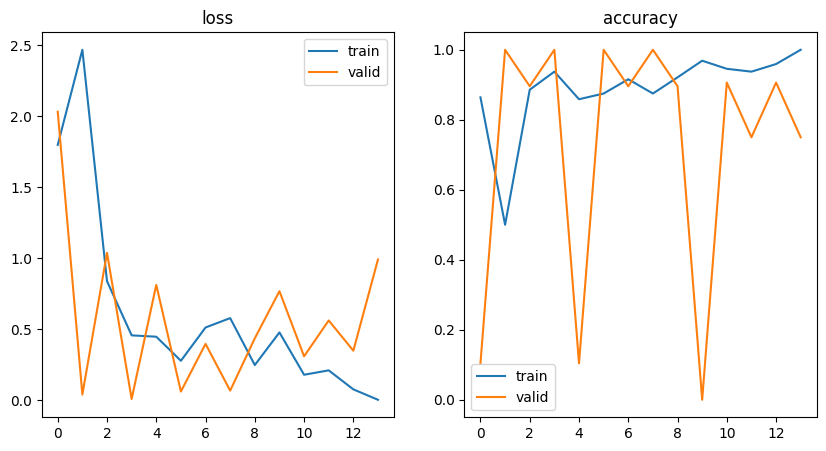

In [13]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_steps = valid_generator.samples//BATCH_SIZE,
                    verbose=True,
                    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
)


# 評価する。
test_loss, test_acc = model.evaluate(valid_generator)
model.save('model.h5')

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

plt.savefig("./metrics.png")

## To Output Submitting CSV

In [14]:
ans = pd.read_csv("/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/sample_submit.csv",  header=None)

In [15]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,0


In [16]:
#!cp './model.h5' '/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/model.h5'
#!cp '/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/model.h5' './model.h5'

In [17]:
TEST_DIR = "./test_img"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(IMG_WIDTH,IMG_HEIGHT), class_mode=None, shuffle=False)

Found 200 images belonging to 1 classes.


In [18]:
pred = model.predict(test_generator)
pred = np.where(pred < 0.5, 0, 1)
# 0:正常音、1:異常音となるように出力値を反転させる

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step


In [19]:
ans[1] = pred
ans.to_csv(path_or_buf = "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/submission_.csv", index=False, header=None)